Run locally on Vrael

In [1]:
import numpy as np
import sys, os
sys.path.append('../lib')
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
from scipy.optimize import fsolve
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from particle import Particle

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from progressBar import ProgressBar

from matplotlib import pyplot as plt

Welcome to JupyROOT 6.10/08


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Internal"

In [3]:
from uproot_methods.classes import TLorentzVector as urTLV

In [4]:
tmu = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/merged/out_CAND.root')['outA']['Tevts']
print tmu.keys(), '\n\n'
branches = [b for b in tmu.keys() if b[:2] == 'MC']
for b in np.sort(branches):
    print b
    
dmu = {}
for b in branches:
    dmu[b] = tmu.array(b)

['LumiBlock', 'MC_B_P', 'MC_B_eta', 'MC_B_phi', 'MC_B_pt', 'MC_D0_P', 'MC_D0_eta', 'MC_D0_phi', 'MC_D0_pt', 'MC_Dst_P', 'MC_Dst_eta', 'MC_Dst_phi', 'MC_Dst_pt', 'MC_Est_mu', 'MC_K_P', 'MC_K_eta', 'MC_K_phi', 'MC_K_pt', 'MC_M2_miss', 'MC_M_vis', 'MC_idxCand', 'MC_mu_IP', 'MC_mu_P', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_pt', 'MC_nB02DstMuX', 'MC_pi_P', 'MC_pi_eta', 'MC_pi_phi', 'MC_pi_pt', 'MC_pis_P', 'MC_pis_eta', 'MC_pis_phi', 'MC_pis_pt', 'MC_prodVtx_B_dxy', 'MC_prodVtx_B_phi', 'MC_prodVtx_B_z', 'MC_prodVtx_D0_dxy', 'MC_prodVtx_D0_phi', 'MC_prodVtx_D0_z', 'MC_prodVtx_Dst_dxy', 'MC_prodVtx_Dst_phi', 'MC_prodVtx_Dst_z', 'MC_prodVtx_K_dxy', 'MC_prodVtx_K_phi', 'MC_prodVtx_K_z', 'MC_q2', 'N_trgMu', 'N_vertexes', 'Run', 'eventNumber', 'n_B', 'n_D0', 'n_Dst', 'n_K', 'n_mu', 'n_pi', 'n_pis', 'primaryVtx_sig_xx', 'primaryVtx_sig_xy', 'primaryVtx_sig_xz', 'primaryVtx_sig_yy', 'primaryVtx_sig_yz', 'primaryVtx_sig_zz', 'primaryVtx_x', 'primaryVtx_y', 'primaryVtx_z', 'recoMuon_match_BMuon', 'wh_CLNCen

In [5]:
def create_urTLV(d, k, m):
    px = d[k+'_pt'] * np.cos(d[k+'_phi'])
    py = d[k+'_pt'] * np.sin(d[k+'_phi'])
    pz = d[k+'_pt'] * np.sinh(d[k+'_eta']).astype(np.float64)
    
    e = np.hypot(m, d[k+'_P'])
    return urTLV.TLorentzVectorArray(px, py, pz, e)

In [6]:
PB = create_urTLV(dmu, 'MC_B', 1e-3*Particle.from_string('B0').mass)
Pmu = create_urTLV(dmu, 'MC_mu', 1e-3*Particle.from_string('mu').mass)
PDst = create_urTLV(dmu, 'MC_Dst', 1e-3*Particle.from_string('D*-').mass)

Pv = Pmu + PDst

1.9465706913024405e-07 3.1635499060734054e-05


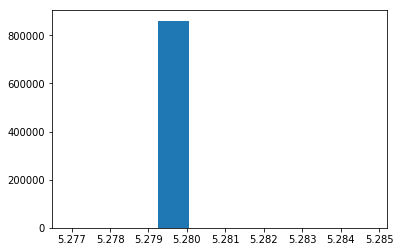

In [7]:
plt.hist(PB.mass)
print np.mean(PB.mass)-1e-3*Particle.from_string('B0').mass, np.std(PB.mass)

Now get the B momentum form different approximations

## MC truth

In [43]:
MCtruth = {}
MCtruth['B_pz'] = PB.z
MCtruth['B_pt'] = PB.pt
MCtruth['B_p3'] = PB.p3

MCtruth['PB'] = PB

MCtruth['M2_miss'] = dmu['MC_M2_miss']
MCtruth['q2'] = dmu['MC_q2']

## Longitudinal Approx (a-la-LHCb)

In [45]:
LongApp = {}
LongApp['B_pz'] = Pv.z * 1e-3*Particle.from_string('B0').mass / Pv.mass
LongApp['B_p3'] = PB.p3 * LongApp['B_pz'] / PB.z
LongApp['B_pt'] = np.hypot(LongApp['B_p3'].x, LongApp['B_p3'].y)

e = np.sqrt(LongApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
LongApp['PB'] = urTLV.TLorentzVectorArray(LongApp['B_p3'].x, LongApp['B_p3'].y, LongApp['B_p3'].z, e)

LongApp['M2_miss'] = (LongApp['PB'] - Pv).mass2
LongApp['q2'] = (LongApp['PB'] - PDst).mass2

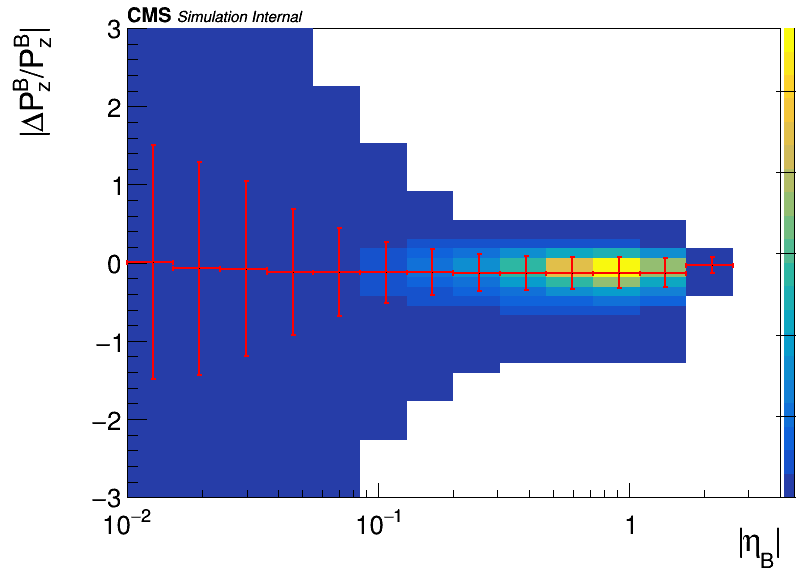

In [10]:
h = create_TH2D(
            np.column_stack((np.abs(PB.eta), (PB.z-LongApp['B_pz'])/PB.z)),
            binning = [np.logspace(-2, np.log10(4), 15), np.linspace(-3, 3, 50)],
            axis_title = ['|#eta_{B}|', '|#DeltaP_{z}^{B}/P_{z}^{B}|', '']
           )

hpfy = h.ProfileX('hpfy', 1, -1, 's')
hpfy.SetLineColor(2)
c = drawOnCMSCanvas(CMS_lumi, [h, hpfy], ['colz', 'sameE1'])
c.SetLogx()

## Transverse Approx

In [11]:
TranApp = {}
TranApp['B_pt'] = Pv.pt * 1e-3*Particle.from_string('B0').mass / Pv.mass
TranApp['B_p3'] = PB.p3 * TranApp['B_pt'] / PB.pt
TranApp['B_pz'] = TranApp['B_p3'].z

e = np.sqrt(TranApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
TranApp['PB'] = urTLV.TLorentzVectorArray(TranApp['B_p3'].x, TranApp['B_p3'].y, TranApp['B_p3'].z, e)

TranApp['M2_miss'] = (TranApp['PB'] - Pv).mass2
TranApp['q2'] = (TranApp['PB'] - PDst).mass2

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


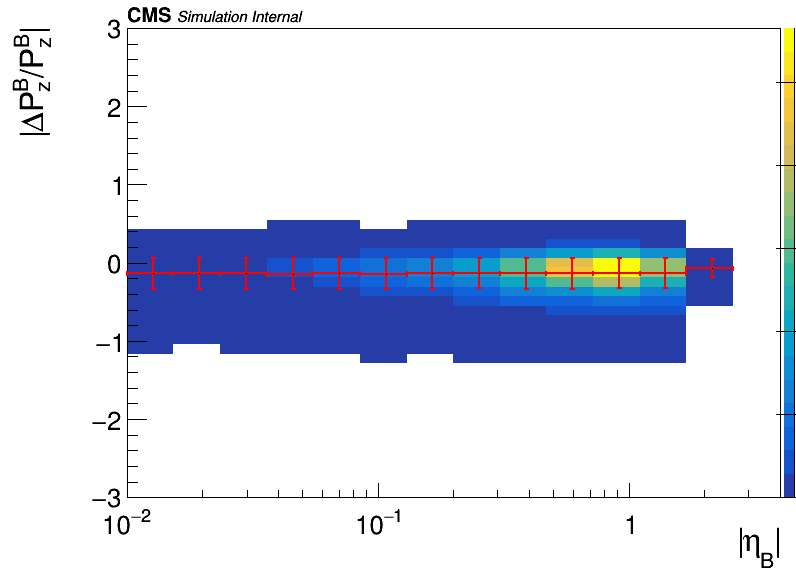

In [12]:
h = create_TH2D(
            np.column_stack((np.abs(PB.eta), (PB.z-TranApp['B_pz'])/PB.z)),
            binning = [np.logspace(-2, np.log10(4), 15), np.linspace(-3, 3, 50)],
            axis_title = ['|#eta_{B}|', '|#DeltaP_{z}^{B}/P_{z}^{B}|', '']
           )

hpfy = h.ProfileX('hpfy', 1, -1, 's')
hpfy.SetLineColor(2)
c = drawOnCMSCanvas(CMS_lumi, [h, hpfy], ['colz', 'sameE1'])
c.SetLogx()

In [13]:
np.min(TranApp['q2'])

-0.590082660866301

## Corrected Transverse App

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


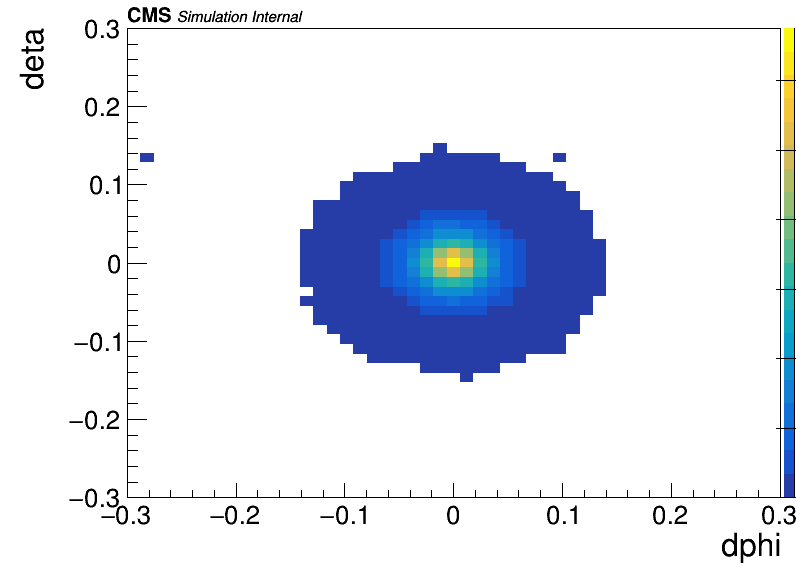

In [18]:
dphi = Pv.phi - PB.phi
dphi = np.where(np.abs(dphi) > np.pi, dphi - np.sign(dphi)*2*np.pi, dphi)
deta = Pv.eta - PB.eta
h = create_TH2D(
            np.column_stack((dphi, deta)),
            binning = [np.linspace(-0.3, 0.3, 50), np.linspace(-0.3, 0.3, 50)],
            axis_title = ['dphi', 'deta', '']
           )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])

In [55]:
CTranApp = {}
CTranApp['B_pt'] = (Pv.x*PB.x + Pv.y*PB.y)/PB.pt * 1e-3*Particle.from_string('B0').mass / Pv.mass
# CTranApp['B_pt'] = (1+0.5*0.25**2)*(Pv.x*PB.x + Pv.y*PB.y)/PB.pt * 1e-3*Particle.from_string('B0').mass / Pv.mass
CTranApp['B_p3'] = PB.p3 * TranApp['B_pt'] / PB.pt
CTranApp['B_pz'] = TranApp['B_p3'].z

e = np.sqrt(TranApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
CTranApp['PB'] = urTLV.TLorentzVectorArray(TranApp['B_p3'].x, TranApp['B_p3'].y, TranApp['B_p3'].z, e)

CTranApp['M2_miss'] = (TranApp['PB'] - Pv).mass2
CTranApp['q2'] = (TranApp['PB'] - PDst).mass2

(array([1.00000e+00, 2.50000e+01, 2.79000e+02, 1.09500e+03, 2.82200e+03,
        5.82000e+03, 1.21690e+04, 2.79480e+04, 8.33180e+04, 7.27356e+05]),
 array([-2.65220575e-01, -2.38695829e-01, -2.12171082e-01, -1.85646336e-01,
        -1.59121589e-01, -1.32596843e-01, -1.06072097e-01, -7.95473503e-02,
        -5.30226039e-02, -2.64978575e-02,  2.68888289e-05]),
 <a list of 10 Patch objects>)

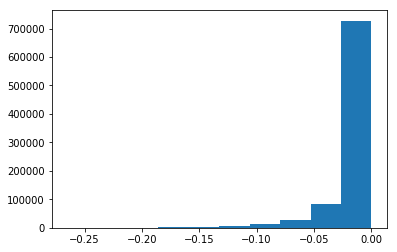

In [56]:
plt.hist(CTranApp['B_pt'] - TranApp['B_pt'])

## BoostBCM

In [ ]:
def equations(x, *a):
    g, pxst, pyst, pzst = x
    nx, ny, nz, e, px, py, pz, mv = a
    
    gb = np.sqrt(g*g-1)
    
    eqE = g*e - gb*nx*px - gb*ny*py - gb*nz*pz
    eqE -= np.sqrt(mv*mv + pxst*pxst + pyst*pyst + pzst*pzst)
    
    eqPx = -gb*nx*e 
    eqPx += px*( 1. + (g-1)*nx*nx )
    eqPx += py*(g-1)*nx*ny
    eqPx += pz*(g-1)*nx*nz
    eqPx -= pxst
    
    eqPy = -gb*ny*e
    eqPy += px*(g-1)*ny*nx
    eqPy += py*( 1. + (g-1)*ny*ny )
    eqPy += pz*(g-1)*ny*nz
    eqPy -= pyst
    
    eqPz = -gb*nz*e
    eqPz += px*(g-1)*nz*nx
    eqPz += py*(g-1)*nz*ny
    eqPz += pz*( 1. + (g-1)*nz*nz )
    eqPz -= pzst
    
    return (eqE, eqPx, eqPy, eqPz)

In [ ]:
pxst = 1
pyst = 20
pzst = 0
m = 1
est = np.sqrt(m**2 + pxst**2 + pyst**2 + pzst**2)
pCM = rt.TLorentzVector(pxst, pyst, pzst, est)
pCM.Print()

In [ ]:
pxt = 10
pyt = 10
pzt = 0
mt = 5
et = np.sqrt(mt**2 + pxt**2 + pyt**2 + pzt**2)
p = rt.TLorentzVector(pxt, pyt, pzt, et)
p.BoostVector().Print()
print p.Gamma()
print p.Beta()

In [ ]:
pLab = rt.TLorentzVector(pxst, pyst, pzst, est)
pLab.Boost(p.BoostVector())
pLab.Print()
pLab.M()

In [ ]:
p = rt.TLorentzVector(23.635, -3.8753, -7.6531, 25.692)
p.BoostVector().Print()
print p.M()
pLab = rt.TLorentzVector(19.621, -2.2307, -6.6636, 21.242)
print pLab.M()
pCM = pLab.Clone()
pCM.Boost(-p.BoostVector())

In [ ]:
nx = p.Px()/p.P()
print nx
ny = p.Py()/p.P()
print ny
nz = p.Pz()/p.P()
print nz

# equations([p.Gamma(), 1e3*pCM.Px(), 1e3*pCM.Py(), 1e3*pCM.Pz()], 
#           nx, ny, nz, 
#           1e3*pLab.E(), 1e3*pLab.Px(), 1e3*pLab.Py(), 1e3*pLab.Pz(), 1e3*m)

out = equations([p.Gamma(), pCM.Px(), pCM.Py(), pCM.Pz()], 
          nx, ny, nz, 
          pLab.E(), pLab.Px(), pLab.Py(), pLab.Pz(), pCM.M())

print 'Var:' + (4*' {:.3f}').format(p.Gamma(), pCM.Px(), pCM.Py(), pCM.Pz())
print 'Pars:' + (8*' {:.3f}').format(nx, ny, nz, pLab.E(), pLab.Px(), pLab.Py(), pLab.Pz(), pCM.M())
print 'Red:' + (4*' {:1.3e}').format(*out)

### Test

Get the arguments

In [ ]:
choice = np.random.randint(low=0, high=len(PB)-1, size=1)

In [ ]:
for i_evt in [372182]: #choice:
    print '------- Event', i_evt, '--------'
    nx = PB[i_evt].x/PB[i_evt].p
    ny = PB[i_evt].y/PB[i_evt].p
    nz = PB[i_evt].z/PB[i_evt].p
    e = Pv[i_evt].E
    px = Pv[i_evt].x
    py = Pv[i_evt].y
    pz = Pv[i_evt].z
    mv = Pv[i_evt].mass
    print Pv[i_evt]
    
    # Get the starting estimation from transverse approx
    g_init = TranApp['PB'][i_evt].gamma
    P_vis_lv = rt.TLorentzVector()
    P_vis_lv.SetPxPyPzE(px, py, pz, e)
    P_vis_lv.Boost(-TranApp['PB'][i_evt].boostp3.x, 
                   -TranApp['PB'][i_evt].boostp3.y, 
                   -TranApp['PB'][i_evt].boostp3.z
                  )
    
    pxst_init = P_vis_lv.Px()
    pyst_init = P_vis_lv.Py()
    pzst_init = P_vis_lv.Pz()
    
    print 'Initial status'
    print 'Init: {:.2f} {:.2f} {:.2f} {:.2f}'.format(g_init, pxst_init, pyst_init, pzst_init)
    r0, r1, r2, r3 =  equations((g_init, pxst_init, pyst_init, pzst_init), nx, ny, nz, e, px, py, pz, mv)
    print 'Loss val: {:.2e} {:.2e} {:.2e} {:.2e}'.format(r0, r1, r2, r3)
    print
    
    # Mimization step
    out = fsolve(
               equations, 
               x0=(g_init, pxst_init, pyst_init, pzst_init), 
               args = (nx, ny, nz, e, px, py, pz, mv)
              )
    g_opt, pxst_opt, pyst_opt, pzst_opt = out
    print 'Final status'
    print 'Init: {:.2f} {:.2f} {:.2f} {:.2f}'.format(g_opt, pxst_opt, pyst_opt, pzst_opt)
    r0, r1, r2, r3 =  equations((g_opt, pxst_opt, pyst_opt, pzst_opt), nx, ny, nz, e, px, py, pz, mv)
    print 'Loss val: {:.2e} {:.2e} {:.2e} {:.2e}'.format(r0, r1, r2, r3)
    print
    
    # Get the exact solution
    g_true = PB.gamma[i_evt]

    P_vis_lv = rt.TLorentzVector()
    P_vis_lv.SetPxPyPzE(px, py, pz, e)
    P_vis_lv.Boost(-PB[i_evt].boostp3.x, -PB[i_evt].boostp3.y, -PB[i_evt].boostp3.z)
    
    pxst_true = P_vis_lv.Px()
    pyst_true = P_vis_lv.Py()
    pzst_true = P_vis_lv.Pz()

    print 'True status'
    print PB[i_evt]
    print 'Var:' + (4*' {:.3f}').format(g_true, pxst_true, pyst_true, pzst_true)
    print 'Pars:' + (8*' {:.3f}').format(nx, ny, nz, e, px, py, pz, mv)
    r0, r1, r2, r3 =  equations((g_true, pxst_true, pyst_true, pzst_true), nx, ny, nz, e, px, py, pz, mv)
    print 'Res:' + (4*' {:1.3e}').format(r0, r1, r2, r3)
    print '\n'

In [ ]:
Var: 4.866 0.179 0.957 -0.368
Pars: 0.940 -0.154 -0.304 21.242 19.621 -2.231 -6.664 4.106
Red: -3.197e-14 -1.066e-14 1.554e-15 1.776e-15

### For all events

In [ ]:
gamma = []
maxEntry = min(5000, PB.z.shape[0])
progBar = ProgressBar(maxEntry=maxEntry)
gamma = np.zeros(maxEntry)
for i_evt in range(maxEntry):
    progBar.show(i_evt)
    nx = PB.x[i_evt]/PB.p[i_evt]
    ny = PB.y[i_evt]/PB.p[i_evt]
    nz = PB.z[i_evt]/PB.p[i_evt]
    e = Pv.E[i_evt]
    px = Pv.x[i_evt]
    py = Pv.y[i_evt]
    pz = Pv.z[i_evt]
    mv = Pv.mass[i_evt]
    
    # Get the starting estimation from transverse approx
    g_init = TranApp['PB'].gamma[i_evt]
    P_vis_lv = rt.TLorentzVector()
    P_vis_lv.SetPxPyPzE(Pv.x[i_evt], Pv.y[i_evt], pz, e)
    P_vis_lv.Boost(-TranApp['PB'].boostp3[i_evt].x, -TranApp['PB'].boostp3[i_evt].y, -TranApp['PB'].boostp3[i_evt].z)
    
    pxst_init = P_vis_lv.Px()
    pyst_init = P_vis_lv.Py()
    pzst_init = P_vis_lv.Pz()
    
    # Mimization step
    out = fsolve(
               equations, 
               x0=(g_init, pxst_init, pyst_init, pzst_init), 
               args = (nx, ny, nz, e, px, py, pz, mv)
              )
    g_opt, pxst_opt, pyst_opt, pzst_opt = out
    gamma[i_evt] = g_opt

In [ ]:
gamma = np.array(gamma)

BoostBCM = {}

BoostBCM['gamma'] = gamma
BoostBCM['B_P'] = np.sqrt(np.square(gamma) - 1) * 1e-3*Particle.from_string('B0').mass

BoostBCM['B_p3'] = PB.p3 * BoostBCM['B_P'] / PB.p
BoostBCM['B_pt'] = np.hypot(BoostBCM['B_p3'].x, BoostBCM['B_p3'].y)
BoostBCM['B_pz'] = BoostBCM['B_p3'].z

e = np.sqrt(BoostBCM['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
BoostBCM['PB'] = urTLV.TLorentzVectorArray(BoostBCM['B_p3'].x, BoostBCM['B_p3'].y, BoostBCM['B_p3'].z, e)

BoostBCM['M2_miss'] = (BoostBCM['PB'] - Pv).mass2
BoostBCM['q2'] = (BoostBCM['PB'] - PDst).mass2

# Variable comparison

In [57]:
dic_list = {'MC Truth': MCtruth,
            'Long. approx': LongApp,
            'Trans. approx': TranApp,
            'Correct Trans. approx': CTranApp,
#             'Boost B cm': BoostBCM
           }

In [58]:
def draw_var(vname, xtitle, binning, opt, leg_loc):
    h_l = []

    leg = rt.TLegend(leg_loc[0],leg_loc[1],leg_loc[2],leg_loc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    for n, d in dic_list.iteritems():
        h_aux = create_TH1D(
            d[vname], 
            axis_title=[xtitle, 'Events'], 
            binning=binning, opt=opt
        )
        h_aux.SetLineColor(std_color_list[len(h_l)])
        h_aux.Sumw2()
        leg.AddEntry(h_aux, n, 'l')
        h_l.append(h_aux)
    SetMaxToMaxHist(h_l)


    CMS_lumi.extraText = "     Simulation Preliminary"
    c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')
    c.h_l = h_l
    c.leg = leg
    leg.Draw()
    return c

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


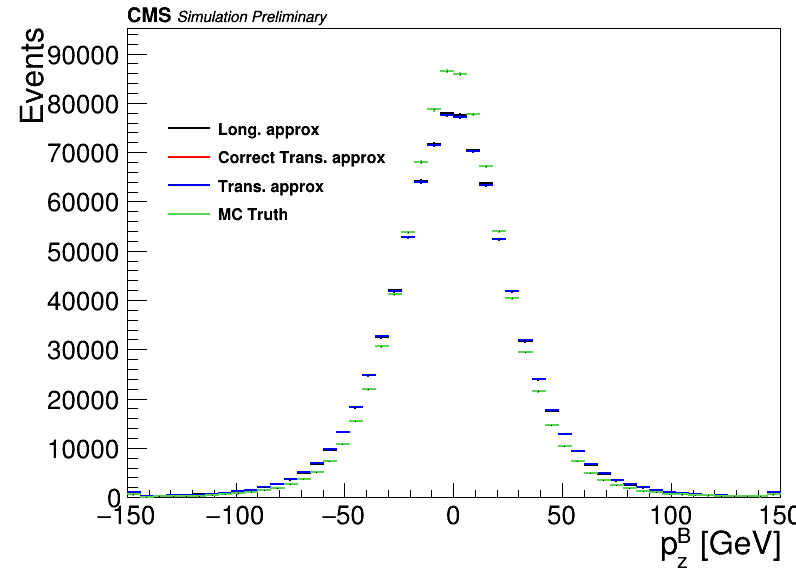

In [59]:
c = draw_var('B_pz', 'p_{z}^{B} [GeV]', binning=[50, -150, 150], opt='underflowoverflow', leg_loc=[0.2,0.6,0.5,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


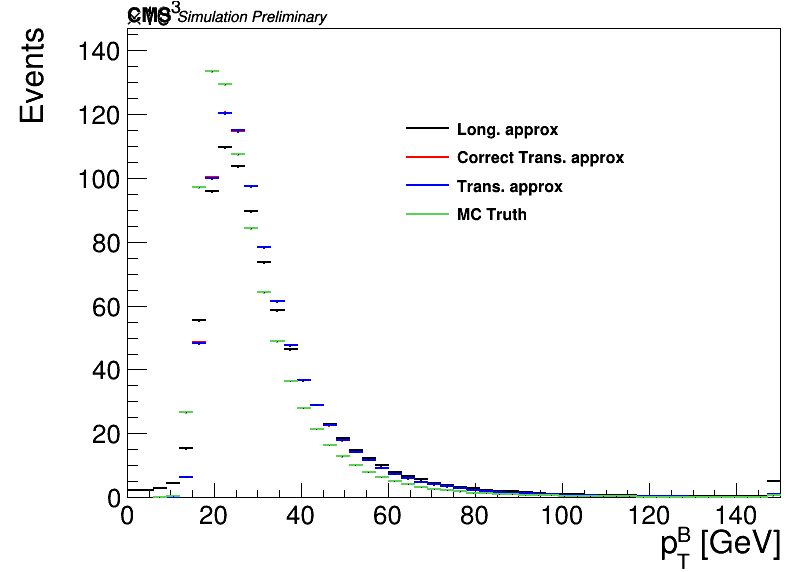

In [60]:
c = draw_var('B_pt', 'p_{T}^{B} [GeV]', binning=[50, 0, 150], opt='underflowoverflow', leg_loc=[0.5,0.6,0.8,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


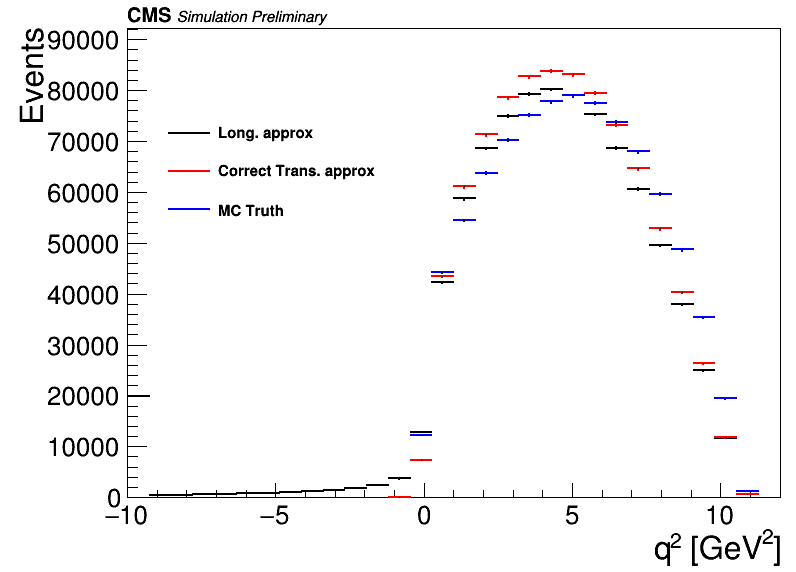

In [40]:
c = draw_var('q2', 'q^{2} [GeV^{2}]', binning=[30, -10, 12], opt='underflow', leg_loc=[0.2,0.6,0.5,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


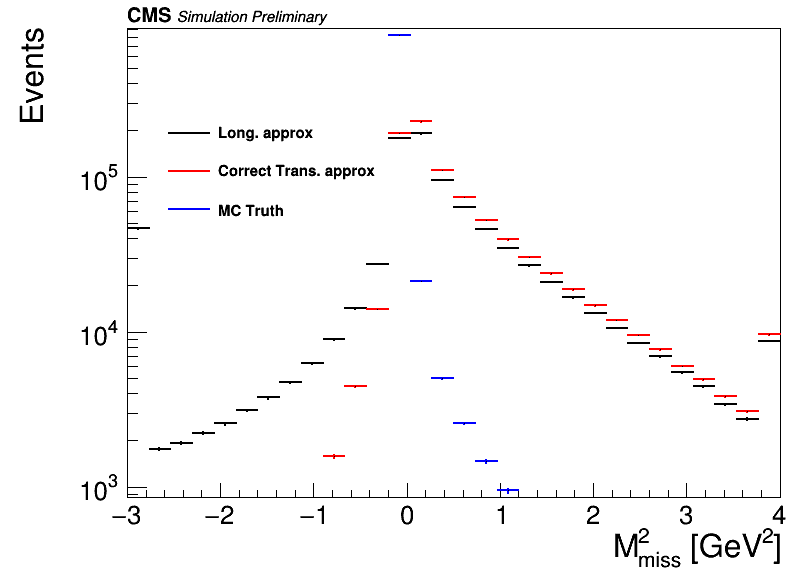

In [41]:
c = draw_var('M2_miss', 'M^{2}_{miss} [GeV^{2}]', binning=[30, -3, 4], opt='underflowoverflow', leg_loc=[0.2,0.6,0.5,0.8])
c.SetLogy()